# Notes
- JPX_Model_LGBM_v20

# To do list

In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc
import seaborn as sns
import scipy.cluster.hierarchy as spc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, accuracy_score

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

!pip install ../input/ta-0101/ta-0.10.1-py3-none-any.whl
import ta
from ta import add_all_ta_features
from ta.utils import dropna

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Processing /kaggle/input/ta-0101/ta-0.10.1-py3-none-any.whl


In [2]:
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def my_calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return pd.DataFrame({'long':[purchase],'short':[short],'net':[purchase - short]})

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [3]:
def analyze_signal(df):
    # preprocess
    df.Date = pd.to_datetime(df.Date)

    # portfolio return analysis
    ret = df.groupby('Date').apply(my_calc_spread_return_per_day, 200, 2)
    ret = ret.reset_index().set_index('Date') \
        .assign(short = lambda x: -1 * x.short)

    # cumulative returns
    new_plot()
    ret.long.cumsum().plot(label='long', figsize=(12,5))
    ret.short.cumsum().plot(label='short')
    ret.net.cumsum().plot(label='net')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('Cumulative Returns')
    log(f'Mean long returns: {ret.long.mean()}')
    log(f'Mean short returns: {ret.short.mean()}')
    log(f'Mean net returns: {ret.net.mean()}')

    # rolling sharpes
    new_plot()
    ret.long.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='long', figsize=(12,5))
    ret.short.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='short')
    ret.net.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='net')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('Rolling Sharpes')
    log(f'Sharpe of long: {ret.long.mean() / ret.long.std()}')
    log(f'Sharpe of short: {ret.short.mean() / ret.short.std()}')
    log(f'Sharpe of net: {ret.net.mean() / ret.net.std()}')
    
    # overall sharpe
    overall_sharpe = calc_spread_return_sharpe(df)
    last_6m_sharpe = calc_spread_return_sharpe(df.loc[lambda x: x.Date.isin(df.Date.drop_duplicates().tail(120))])
    last_3m_sharpe = calc_spread_return_sharpe(df.loc[lambda x: x.Date.isin(df.Date.drop_duplicates().tail(60))])
    log(f'Overall sharpe: {overall_sharpe}')
    log(f'Last 6m sharpe: {last_6m_sharpe}')
    log(f'Last 3m sharpe: {last_3m_sharpe}')

In [4]:
df_pred_val = []
for ver in [11,12,17,19,20,26]:
    df = pd.read_feather(f'../input/jpx-model-lgbm-v{ver}/df_pred_val')
    df['ver'] = ver
    df_pred_val.append(df)
df_pred_val = pd.concat(df_pred_val).reset_index(drop=True)

In [5]:
df_pred_val['Rank_raw'] = df_pred_val.groupby(['ver','Date']).pred_model.rank(method='first', ascending=False).astype(int) - 1
df_pred_val['Rank_demean'] = df_pred_val.groupby(['ver','Date']).pred_model_demean.rank(method='first', ascending=False).astype(int) - 1
df_pred_val['Rank_vol_penalty'] = df_pred_val.groupby(['ver','Date']).pred_model_vol_penalty.rank(method='first', ascending=False).astype(int) - 1

In [6]:
def cal_avg_sharpe(df_pred_val, col, ver1, ver2):
    df = get_avg_df_pred(df_pred_val, col, ver1, ver2)
    sharpe = calc_spread_return_sharpe(df)
    return sharpe

def get_avg_df_pred(df_pred_val, col, ver1, ver2):
    df1 = df_pred_val.loc[lambda x: x.ver==ver1].assign(Rank=lambda x: x[col]).loc[:, ['RowId','Date','SecuritiesCode','Rank','Target']].reset_index(drop=True)
    df2 = df_pred_val.loc[lambda x: x.ver==ver2].assign(Rank=lambda x: x[col]).loc[:, ['RowId','Date','SecuritiesCode','Rank','Target']].reset_index(drop=True)
    df = pd.concat([df1, df2]).groupby(['RowId','Date','SecuritiesCode'])[['Rank','Target']].mean().reset_index()
    df['Rank'] = df.groupby('Date').Rank.rank(method='first', ascending=True).astype(int) - 1
    return df

In [7]:
ver_list = df_pred_val.ver.unique().tolist()
tup_list = list(itertools.product(ver_list, ver_list))
tup_list = list(set([tuple(sorted(list(x))) for x in tup_list]))

result = []
for col in ['Rank_raw','Rank_demean','Rank_vol_penalty']:
    for ver1, ver2 in tup_list:
        sharpe = cal_avg_sharpe(df_pred_val, col, ver1, ver2)
        result.append((col, ver1, ver2, sharpe))
result = pd.DataFrame(result, columns=['col','ver1','ver2','sharpe'])

In [8]:
for col in ['Rank_raw','Rank_demean','Rank_vol_penalty']:
    print(col)
    display(result.loc[lambda x: (x.col==col) & (x.ver1==x.ver2)].sort_values('sharpe', ascending=False))
    display(result.loc[lambda x: (x.col==col) & (x.ver1!=x.ver2)].sort_values('sharpe', ascending=False))
    display(result.loc[lambda x: x.col==col].pivot(index='ver1', columns='ver2', values='sharpe'))

Rank_raw


,col,ver1,ver2,sharpe
4,Rank_raw,20,20,0.191040
11,Rank_raw,26,26,0.177160
20,Rank_raw,17,17,0.159819
1,Rank_raw,19,19,0.153882
0,Rank_raw,11,11,0.149709
3,Rank_raw,12,12,0.145860


,col,ver1,ver2,sharpe
5,Rank_raw,17,20,0.240142
8,Rank_raw,12,20,0.225363
13,Rank_raw,19,20,0.218982
7,Rank_raw,20,26,0.212879
17,Rank_raw,12,19,0.204045
19,Rank_raw,17,26,0.201798
10,Rank_raw,17,19,0.199867
12,Rank_raw,11,26,0.197669
2,Rank_raw,19,26,0.195100
18,Rank_raw,11,20,0.190196


ver2,11,12,17,19,20,26
ver1,,,,,,
11,0.149709,0.142546,0.172554,0.162920,0.190196,0.197669
12,NaN,0.145860,0.155784,0.204045,0.225363,0.185319
17,NaN,NaN,0.159819,0.199867,0.240142,0.201798
19,NaN,NaN,NaN,0.153882,0.218982,0.195100
20,NaN,NaN,NaN,NaN,0.191040,0.212879
26,NaN,NaN,NaN,NaN,NaN,0.177160


Rank_demean


,col,ver1,ver2,sharpe
25,Rank_demean,20,20,0.172167
32,Rank_demean,26,26,0.169205
41,Rank_demean,17,17,0.142740
22,Rank_demean,19,19,0.139433
21,Rank_demean,11,11,0.139320
24,Rank_demean,12,12,0.129019


,col,ver1,ver2,sharpe
26,Rank_demean,17,20,0.214073
34,Rank_demean,19,20,0.202690
23,Rank_demean,19,26,0.196613
31,Rank_demean,17,19,0.196118
28,Rank_demean,20,26,0.191828
29,Rank_demean,12,20,0.191726
40,Rank_demean,17,26,0.187498
38,Rank_demean,12,19,0.185075
33,Rank_demean,11,26,0.183449
39,Rank_demean,11,20,0.171905


ver2,11,12,17,19,20,26
ver1,,,,,,
11,0.13932,0.126569,0.155666,0.150862,0.171905,0.183449
12,NaN,0.129019,0.143035,0.185075,0.191726,0.143591
17,NaN,NaN,0.142740,0.196118,0.214073,0.187498
19,NaN,NaN,NaN,0.139433,0.202690,0.196613
20,NaN,NaN,NaN,NaN,0.172167,0.191828
26,NaN,NaN,NaN,NaN,NaN,0.169205


Rank_vol_penalty


,col,ver1,ver2,sharpe
43,Rank_vol_penalty,19,19,0.210763
46,Rank_vol_penalty,20,20,0.186588
62,Rank_vol_penalty,17,17,0.182802
53,Rank_vol_penalty,26,26,0.178678
45,Rank_vol_penalty,12,12,0.166620
42,Rank_vol_penalty,11,11,0.139996


,col,ver1,ver2,sharpe
55,Rank_vol_penalty,19,20,0.220244
49,Rank_vol_penalty,20,26,0.197043
51,Rank_vol_penalty,12,17,0.195422
47,Rank_vol_penalty,17,20,0.194639
59,Rank_vol_penalty,12,19,0.192236
52,Rank_vol_penalty,17,19,0.189215
54,Rank_vol_penalty,11,26,0.188484
50,Rank_vol_penalty,12,20,0.181011
44,Rank_vol_penalty,19,26,0.174965
60,Rank_vol_penalty,11,20,0.165603


ver2,11,12,17,19,20,26
ver1,,,,,,
11,0.139996,0.126037,0.122570,0.159324,0.165603,0.188484
12,NaN,0.166620,0.195422,0.192236,0.181011,0.122198
17,NaN,NaN,0.182802,0.189215,0.194639,0.131934
19,NaN,NaN,NaN,0.210763,0.220244,0.174965
20,NaN,NaN,NaN,NaN,0.186588,0.197043
26,NaN,NaN,NaN,NaN,NaN,0.178678


Rank_demean 17 20
[2022-07-03 18:05:50] Mean long returns: 0.11492469834714376
[2022-07-03 18:05:50] Mean short returns: 0.12611940720365755
[2022-07-03 18:05:50] Mean net returns: 0.24104410555080155
[2022-07-03 18:05:50] Sharpe of long: 0.054939818744685856
[2022-07-03 18:05:50] Sharpe of short: 0.05281662789198884
[2022-07-03 18:05:50] Sharpe of net: 0.2140734357453359
[2022-07-03 18:05:52] Overall sharpe: 0.2140734357453359
[2022-07-03 18:05:52] Last 6m sharpe: 0.20357388569624352
[2022-07-03 18:05:52] Last 3m sharpe: 0.08931256738773131
Rank_raw 17 20
[2022-07-03 18:05:55] Mean long returns: 0.14190455512033093
[2022-07-03 18:05:55] Mean short returns: 0.17287980829684205
[2022-07-03 18:05:55] Mean net returns: 0.314784363417173
[2022-07-03 18:05:55] Sharpe of long: 0.06608815819589167
[2022-07-03 18:05:55] Sharpe of short: 0.07201644348176056
[2022-07-03 18:05:55] Sharpe of net: 0.24014201070654836
[2022-07-03 18:05:56] Overall sharpe: 0.24014201070654836
[2022-07-03 18:05:56] La

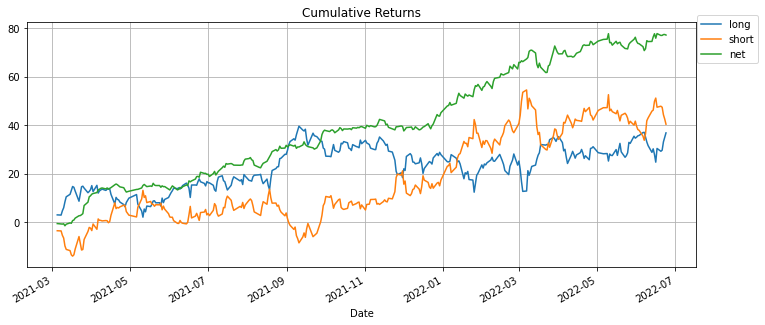

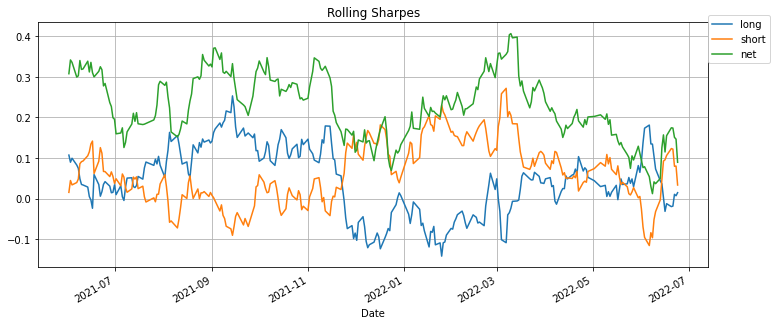

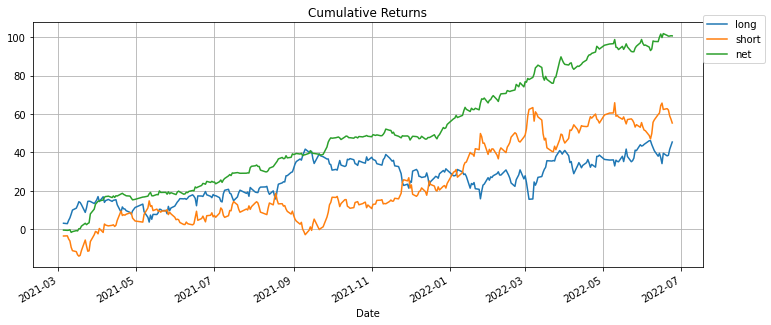

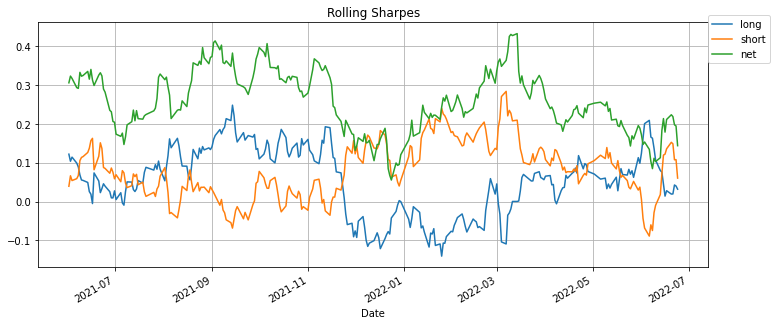

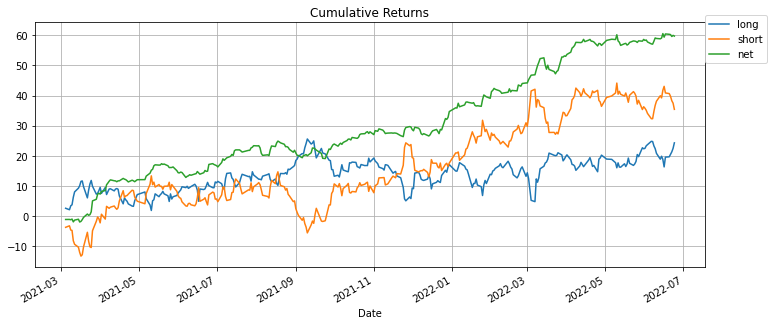

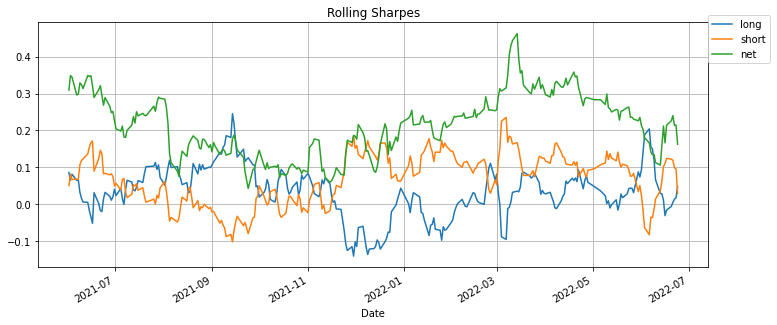

In [9]:
res = result.sort_values(['col','sharpe'], ascending=[1,0]).groupby('col').head(1)
for col, ver1, ver2, _ in list(res.to_records(index=False)):
    print(col, ver1, ver2)
    df_pred = get_avg_df_pred(df_pred_val, col, ver1, ver2)
    analyze_signal(df_pred)

# Debug